# DETR : How to setup a custom dataset

In this tutorial we're gonna explore how to setup a dataset so that you can train your DETR Model.
For the purpose of this tutorial, we're gonna use the Hard Hat Workers Dataset: https://public.roboflow.com/object-detection/hard-hat-workers


<img src="../images/datasetsupport.png"></img>

This tutorial assume that at lease COCO, VOC or a dataset following the tensorflow csv format is download on your machine.


### Download and unzip files

Copy paste your download link bellow to download the dataset into your home/data folder (feel free to set the path you want)

In [1]:
!cd

#!mkdir ~/data/
#!mkdir ~/data/hardhat/
#!wget -O ~/data/hardhat/hard-hat-workers-dataset.zip DOWNLOAD_LINK_HERE
#!unzip ~/data/hardhat/hard-hat-workers-dataset.zip -d ~/data/hardhat/
#!ls ~/data/hardhat/

## 2. Add detr_tf to your PYTHONPATH

In [1]:
import sys
# Set the path to the repository here
sys.path.append("../")
import detr_tf

## 3. Setup a custom dataset


To setup a custom dataset, the following steps must be run.

- **Seup your data**: The first one is specific to your dataset format and must be implement by yourself. That being said, detr_tf already support popular dataset format like **coco** , **voc** and **tensorflow object detection csv**.

- **DETR transformations/augmentations**: detr_tf provide you with the transformations and augmentations operations to apply on your data
- **Image normalization**: detr_tf provide you with the normalizations operations to apply on your image before to call your model
- **Tensorflow Dataset**: Once you're dataset is ready, we're going to setup a Tensorflow Dataset that can be used to train or finetune DETR.


<img src="../images/tutorials/data-pipeline.png"></img>

### a) Create your config


The config file support a lot of parameters but for the sake of simplicity, we're gonna start to change only some parameters related to the dataset. 

In [2]:
from detr_tf.training_config import TrainingConfig
from os.path import expanduser
import os


class CustomConfig(TrainingConfig):

    def __init__(self):
        super().__init__()
        
        # Dataset info
        #self.datadir = os.path.join(expanduser("~"), "../data/WIDERface/")
        self.datadir = os.path.join("../data/WIDERface/")
        # The model is trained using fixed size images.
        # The following is the desired target image size
        self.image_size = (480, 720)
        
config = CustomConfig()

### b) Setup your data : Getting started with the Hard hat Workers Dataset


The hard hat workers dataset is made of two folder, train and test. In each folder, we can find an annotation file (**_annotations.csv**) that we we'll use to get the bbox of each image.

As we can see bellow, the annotation training file is a list of 20231 boudinx box where some bbox can belongs to the same Image. Each bbox is defined by four coordinates (xmin, ymin, xmax, ymax). Also, each bbox can belongs to the following class "helmet", "person" and "head".

In [3]:
import copy

def exctraction_info(name, test=False):
    names = []
    bbx = []
    temp = []
    
    file_train = open(name, 'r')
    lines = file_train.readlines()
    
    for i in range(len(lines)):
        lines[i]=lines[i][:-1]
        
        if lines[i][-4:]=='.jpg':
            temp[:] = []
            #name =  "WIDER_train/images/"
            names.append(lines[i])
            if not test:
                i+=1
                faces = int(lines[i])
                m=i

                for n in range(1,faces+1):
                    ints = [int(i) for i in lines[i+n][:-1].split()]
                    temp.append(ints)

                bbx.append(copy.deepcopy(temp))
    return names, bbx

names_train, bbx_train = exctraction_info('../data/WIDERface/wider_face_split/wider_face_train_bbx_gt.txt')
names_val, bbx_val = exctraction_info('../data/WIDERface/wider_face_split/wider_face_val_bbx_gt.txt')
names_test, bbx_test = exctraction_info('../data/WIDERface/wider_face_split/wider_face_test_filelist.txt', True)

print(len(names_train), len(bbx_train))
print(len(names_val), len(bbx_val))
print(len(names_test), len(bbx_test))

12880 12880
3226 3226
16097 0


## Adapting my dataset to this pipeline

In [9]:
import pandas as pd
import imagesize

# Set the class name.
CLASS_NAMES = ["head"]
# Add the background class at the begining
CLASS_NAMES = ["background"] + CLASS_NAMES

transformation = []
names = []
clas = []
width = []
height = []

for i in range(len(bbx_train)):
    if len(bbx_train[i])<100:
        for j in bbx_train[i]:
            transformation.append(j)
            names.append(os.path.join(config.datadir, "WIDER_train/images/",names_train[i]))
            w, h = imagesize.get(os.path.join(config.datadir, "WIDER_train/images/",names_train[i]))
            width.append(w)
            height.append(h)
            clas.append("head")
print(len(names), len(transformation))


101170 101170


In [10]:
import numpy as np

df = pd.DataFrame(list(zip(names, width, height,clas,np.asarray(transformation)[:,0],
                           np.asarray(transformation)[:,1],
                          np.asarray(transformation)[:,0]+np.asarray(transformation)[:,2]
                           ,np.asarray(transformation)[:,1]+np.asarray(transformation)[:,3])),
                  columns =['filename','width','height','class','xmin','ymin','xmax','ymax'])
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../data/WIDERface/WIDER_train/images/0--Parade...,1024,1385,head,449,330,571,479
1,../data/WIDERface/WIDER_train/images/0--Parade...,1024,1432,head,361,98,624,437
2,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,78,221,85,229
3,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,78,238,92,255
4,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,113,212,124,227
...,...,...,...,...,...,...,...,...
101165,../data/WIDERface/WIDER_train/images/9--Press_...,1024,683,head,462,140,726,502
101166,../data/WIDERface/WIDER_train/images/9--Press_...,1024,1353,head,362,108,576,385
101167,../data/WIDERface/WIDER_train/images/9--Press_...,1024,1536,head,495,222,660,444
101168,../data/WIDERface/WIDER_train/images/9--Press_...,1024,705,head,244,46,754,660


In [18]:
import pandas as pd
import os

# Open annotation file
anns = pd.read_csv(os.path.join(config.datadir, 'train/_annotations.csv'))

# Set the class name.
CLASS_NAMES = anns["class"].unique().tolist()
# Add the background class at the begining
CLASS_NAMES = ["background"] + CLASS_NAMES

print("CLASS_NAMES", CLASS_NAMES)
anns

FileNotFoundError: [Errno 2] No such file or directory: '../data/WIDERface/train/_annotations.csv'

Let's display one image with the associated bbox to get a grasps of what the dataset looks like.

In [11]:
df.to_csv("train.csv")

../data/WIDERface/WIDER_train/images/../data/WIDERface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg


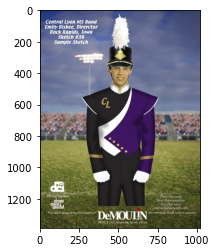

In [8]:
import imageio
import matplotlib.pyplot as plt
import os

filenames = df["filename"].unique().tolist()
img_id = filenames.index("../data/WIDERface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg")
image_anns = df[df["filename"] == filenames[img_id]]# filenames[img_id]]

print(os.path.join(config.datadir, "WIDER_train/images/", filenames[img_id]))
image = imageio.imread(filenames[img_id])
plt.imshow(image)

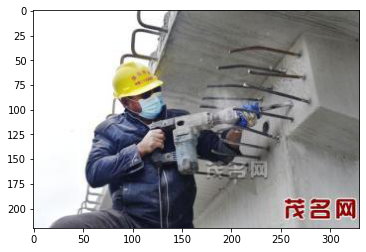

In [8]:
import imageio
import matplotlib.pyplot as plt
import os

# Select all unique filenames. We'll be usefull later to setup the datapipeline
filenames = anns["filename"].unique().tolist()

img_id = filenames.index("003225_jpg.rf.03205181938e7f642273dd4f106ea3e1.jpg")
# Select all the annotatio (bbox and class) on this image
image_anns = anns[anns["filename"] == filenames[img_id]]# filenames[img_id]]

# Open the image
image = imageio.imread(os.path.join(config.datadir, "train", filenames[img_id]))
plt.imshow(image)

####  Retrive the targert class, bbox and display the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1]
CLASS_NAMES ['background', 'head']
t_class [1]


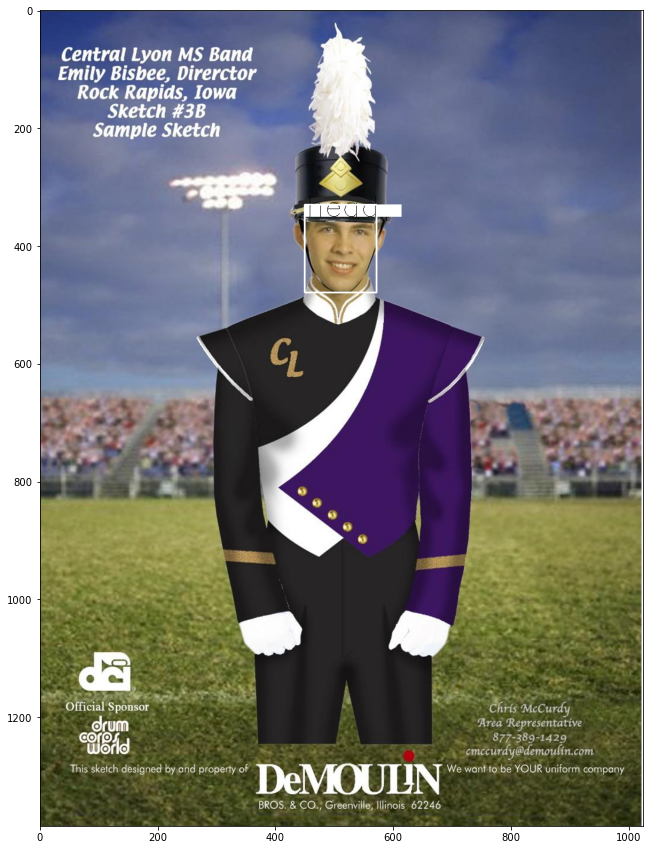

In [17]:
from detr_tf.inference import numpy_bbox_to_image
from detr_tf import bbox
import numpy as np


# first convert all string class to number (the target class)
t_class = image_anns["class"].map(lambda x: CLASS_NAMES.index(x)).to_numpy()
print(t_class)
# Select the width of each image (should be the same since all the ann belongs to the same image)
width = image_anns["width"].to_numpy()
# Select the height of each image
height = image_anns["height"].to_numpy()
# Select the xmin, ymin, xmax and ymax of each bbox
# Then, normalized the bbox to be between and 0 and 1
# Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
bbox_list = image_anns[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 

t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)

print("CLASS_NAMES", CLASS_NAMES)
print("t_class", t_class)

# Now we can apply the target bbox and the target class on the image
img = (image / 255).astype(np.float32)
img = numpy_bbox_to_image(img, t_bbox, t_class, scores=None, class_name=CLASS_NAMES)
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CLASS_NAMES ['background', 'head', 'helmet', 'person']
t_class [2 3]


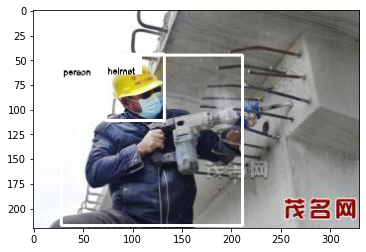

In [9]:
from detr_tf.inference import numpy_bbox_to_image
from detr_tf import bbox
import numpy as np


# first convert all string class to number (the target class)
t_class = image_anns["class"].map(lambda x: CLASS_NAMES.index(x)).to_numpy()
# Select the width of each image (should be the same since all the ann belongs to the same image)
width = image_anns["width"].to_numpy()
# Select the height of each image
height = image_anns["height"].to_numpy()
# Select the xmin, ymin, xmax and ymax of each bbox
# Then, normalized the bbox to be between and 0 and 1
# Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
bbox_list = image_anns[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 
t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)

print("CLASS_NAMES", CLASS_NAMES)
print("t_class", t_class)

# Now we can apply the target bbox and the target class on the image
img = (image / 255).astype(np.float32)
img = numpy_bbox_to_image(img, t_bbox, t_class, scores=None, class_name=CLASS_NAMES)
plt.imshow(img)

### c) DETR Transformation / Augmentations

The following code show how to use the detr_transform method to transform your images before the training steps. This same method can apply augmentation on the images if needed. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


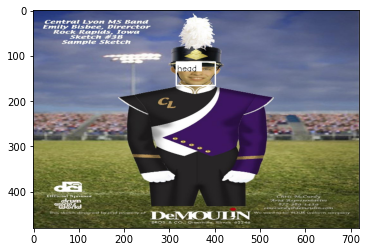

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


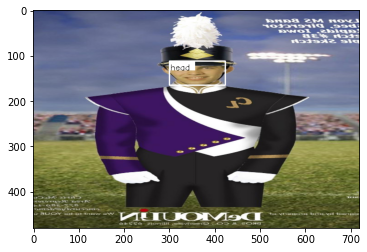

In [18]:
from detr_tf.data.transformation import detr_transform

# Transform/Resize images without any augmentation -> for validation
val_img, val_t_bbox, val_t_class = detr_transform(image, t_bbox,  t_class, config, augmentation=False)
# Transform/Resize images with augmentations operations -> for training
train_img, train_t_bbox, train_t_class = detr_transform(image, t_bbox,  t_class, config, augmentation=True)

# Display image with resize only
display_img = numpy_bbox_to_image(val_img / 255., val_t_bbox, val_t_class, scores=None, class_name=CLASS_NAMES)
plt.imshow(display_img)
plt.show()
# Display image with transformations
display_img = numpy_bbox_to_image(train_img / 255, train_t_bbox, train_t_class, scores=None, class_name=CLASS_NAMES)
plt.imshow(display_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


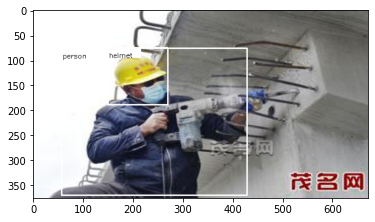

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


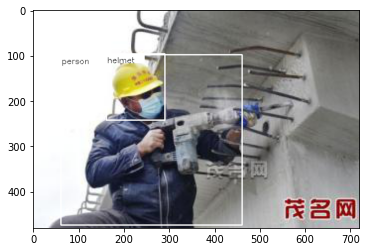

In [10]:
from detr_tf.data.transformation import detr_transform

# Transform/Resize images without any augmentation -> for validation
val_img, val_t_bbox, val_t_class = detr_transform(image, t_bbox,  t_class, config, augmentation=False)
# Transform/Resize images with augmentations operations -> for training
train_img, train_t_bbox, train_t_class = detr_transform(image, t_bbox,  t_class, config, augmentation=True)

# Display image with resize only
display_img = numpy_bbox_to_image(val_img / 255., val_t_bbox, val_t_class, scores=None, class_name=CLASS_NAMES)
plt.imshow(display_img)
plt.show()
# Display image with transformations
display_img = numpy_bbox_to_image(train_img / 255, train_t_bbox, train_t_class, scores=None, class_name=CLASS_NAMES)
plt.imshow(display_img)
plt.show()

### d) Image normalization

To be used by the model, you must first normalized your images. The normalizition method depends of the weights and the model you're using. The best way to get the right normalized is simply to pass your config class to the normalization method. The normalization parameters will be update if needed by the model later and so your datapipeline.

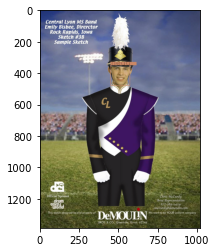

In [19]:
from detr_tf.data import processing
# Normalized images
normalized_image = processing.normalized_images(image, config)

# The method now use the config class to know the normalization to applied on the image
# before to render the outputs
display_img = numpy_bbox_to_image(
    normalized_image, t_bbox, t_class, scores=None, class_name=CLASS_NAMES, config=config
)

plt.imshow(display_img)

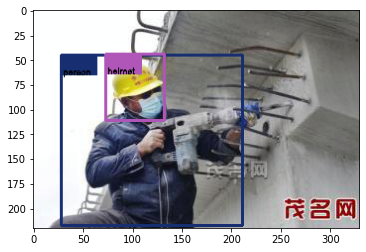

In [11]:
from detr_tf.data import processing
# Normalized images
normalized_image = processing.normalized_images(image, config)

# The method now use the config class to know the normalization to applied on the image
# before to render the outputs
display_img = numpy_bbox_to_image(
    normalized_image, t_bbox, t_class, scores=None, class_name=CLASS_NAMES, config=config
)

plt.imshow(display_img)

 ### e) Tensorflow Dataset
 
The final step is to setup a Tensorflow dataset. To get the most out of tf.Dataset, we need the following:

- A list of index where each index can be used to retrieve an  image with its associated bbox
- A method, which given an index will load the image and the annotations.

First, let's define the dataet with the index list  only.
The  function bellow is not finished yet but will be complete in the next cells

In [20]:


import tensorflow as tf
from random import shuffle

def load_wider(df, batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    # Open annotation file (train or val)
    #anns = pd.read_csv(os.path.join(config.datadir, f'{train_val}/_annotations.csv'))
    anns = df
    # Set the class name and add the background at the begining
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    # Select all the unique images in this dataset
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    shuffle(indexes)
    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    return dataset


dataset = load_wider(df, 1, config, augmentation=False)
for i, index in enumerate(dataset):
    print("Image indice", index)
    if i > 10: break

Image indice tf.Tensor(1245, shape=(), dtype=int32)
Image indice tf.Tensor(9846, shape=(), dtype=int32)
Image indice tf.Tensor(7195, shape=(), dtype=int32)
Image indice tf.Tensor(1885, shape=(), dtype=int32)
Image indice tf.Tensor(12038, shape=(), dtype=int32)
Image indice tf.Tensor(9868, shape=(), dtype=int32)
Image indice tf.Tensor(8477, shape=(), dtype=int32)
Image indice tf.Tensor(7983, shape=(), dtype=int32)
Image indice tf.Tensor(12790, shape=(), dtype=int32)
Image indice tf.Tensor(9812, shape=(), dtype=int32)
Image indice tf.Tensor(8493, shape=(), dtype=int32)
Image indice tf.Tensor(6941, shape=(), dtype=int32)


In [12]:
import tensorflow as tf
from random import shuffle

def load_hardhat(train_val, batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    # Open annotation file (train or val)
    anns = pd.read_csv(os.path.join(config.datadir, f'{train_val}/_annotations.csv'))
    # Set the class name and add the background at the begining
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    # Select all the unique images in this dataset
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    shuffle(indexes)
    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    return dataset


dataset = load_hardhat("test", 1, config, augmentation=False)
for i, index in enumerate(dataset):
    print("Image indice", index)
    if i > 10: break

Image indice tf.Tensor(981, shape=(), dtype=int32)
Image indice tf.Tensor(159, shape=(), dtype=int32)
Image indice tf.Tensor(1462, shape=(), dtype=int32)
Image indice tf.Tensor(1231, shape=(), dtype=int32)
Image indice tf.Tensor(1645, shape=(), dtype=int32)
Image indice tf.Tensor(576, shape=(), dtype=int32)
Image indice tf.Tensor(1392, shape=(), dtype=int32)
Image indice tf.Tensor(992, shape=(), dtype=int32)
Image indice tf.Tensor(599, shape=(), dtype=int32)
Image indice tf.Tensor(575, shape=(), dtype=int32)
Image indice tf.Tensor(1316, shape=(), dtype=int32)
Image indice tf.Tensor(845, shape=(), dtype=int32)


The next step is to map your indexes to actual data. Formally, for each  index, we must defined a method that return:
- One transformed and normalized image (as shown above in this tutorial) of shape (h, w, 3)
- A list of bbox of shape (n, 4) where the 4 values are : (center_x, center_y, width, height) with values between  and 0 and 1
- A list of class of shape (n,1)


The **load_hardhat_data_from_index** method do not include new information but simply reuse the code previously shown in this tutorial.


The new method that we use to map index to data is :

```python
dataset = dataset.map(lambda idx: processing.numpy_fc(
    idx, load_hardhat_data_from_index, 
    filenames=filenames, train_val=train_val, anns=anns, config=config, augmentation=augmentation)
,num_parallel_calls=tf.data.experimental.AUTOTUNE)
```

This method call for each **idx**, the method **load_hardhat_data_from_index** with the following parameters:
**filenames=filenames, train_val=train_val, anns=anns, config=config, augmentation=augmentation**

In [21]:
df["filename"][0]

'../data/WIDERface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg'

In [24]:
import tensorflow as tf
from random import shuffle

from detr_tf.data import processing
from detr_tf.data.transformation import detr_transform

def load_wider_data_from_index(index, filenames, train_val, anns, config, augmentation):
    # Open the image
    
    #image = imageio.imread(os.path.join(config.datadir, f"{train_val}", filenames[img_id]))
    image = imageio.imread(filenames[img_id])
    # Select all the annotatiom (bbox and class) on this image
    image_anns = anns[anns["filename"] == filenames[img_id]]    
    
    # Convert all string class to number (the target class)
    t_class = image_anns["class"].map(lambda x: CLASS_NAMES.index(x)).to_numpy()
    # Select the width&height of each image (should be the same since all the ann belongs to the same image)
    width = image_anns["width"].to_numpy()
    height = image_anns["height"].to_numpy()
    # Select the xmin, ymin, xmax and ymax of each bbox, Then, normalized the bbox to be between and 0 and 1
    # Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
    bbox_list = image_anns[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
    bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 
    t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)
    
    # Transform and augment image with bbox and class if needed
    image, t_bbox, t_class = detr_transform(image, t_bbox, t_class, config, augmentation=augmentation)

    # Normalized image
    image = processing.normalized_images(image, config)
            
    return image.astype(np.float32), t_bbox.astype(np.float32), np.expand_dims(t_class, axis=-1)


def load_wider(train_val, batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    #anns = pd.read_csv(os.path.join(config.datadir, f'{train_val}/_annotations.csv'))
    anns=df
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    shuffle(indexes)

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: processing.numpy_fc(
        idx, load_wider_data_from_index, 
        filenames=filenames, train_val=train_val, anns=anns, config=config, augmentation=augmentation)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset


dataset = load_wider(df, 1, config, augmentation=False)

In [25]:
for i, (image, t_bbox, t_labels) in enumerate(dataset):
    print("shapes", image.shape, t_bbox.shape, t_labels.shape)
    if i > 10: break

shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)
shapes (480, 720, 3) (1, 4) (1, 1)


In [14]:
import tensorflow as tf
from random import shuffle

from detr_tf.data import processing
from detr_tf.data.transformation import detr_transform

def load_hardhat_data_from_index(index, filenames, train_val, anns, config, augmentation):
    # Open the image
    image = imageio.imread(os.path.join(config.datadir, f"{train_val}", filenames[img_id]))
    # Select all the annotatiom (bbox and class) on this image
    image_anns = anns[anns["filename"] == filenames[img_id]]    
    
    # Convert all string class to number (the target class)
    t_class = image_anns["class"].map(lambda x: CLASS_NAMES.index(x)).to_numpy()
    # Select the width&height of each image (should be the same since all the ann belongs to the same image)
    width = image_anns["width"].to_numpy()
    height = image_anns["height"].to_numpy()
    # Select the xmin, ymin, xmax and ymax of each bbox, Then, normalized the bbox to be between and 0 and 1
    # Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
    bbox_list = image_anns[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
    bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 
    t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)
    
    # Transform and augment image with bbox and class if needed
    image, t_bbox, t_class = detr_transform(image, t_bbox, t_class, config, augmentation=augmentation)

    # Normalized image
    image = processing.normalized_images(image, config)
            
    return image.astype(np.float32), t_bbox.astype(np.float32), np.expand_dims(t_class, axis=-1)


def load_hardhat(train_val, batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    anns = pd.read_csv(os.path.join(config.datadir, f'{train_val}/_annotations.csv'))
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    shuffle(indexes)

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: processing.numpy_fc(
        idx, load_hardhat_data_from_index, 
        filenames=filenames, train_val=train_val, anns=anns, config=config, augmentation=augmentation)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset


dataset = load_hardhat("test", 1, config, augmentation=False)
for i, (image, t_bbox, t_labels) in enumerate(dataset):
    print("shapes", image.shape, t_bbox.shape, t_labels.shape)
    if i > 10: break

shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)
shapes (376, 672, 3) (1, 4) (1, 1)


Finally, the only things left to do is to:
- Make sure we do not include images with 0 bbox. (This can happen because of the augmentations)
- Pad the bbox and labels so that we can create a batch even though there is not the same number of bbox per batch.
- Create batch of data

Then, the final tensorflow data pipeline will looks like this.

In [29]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../data/WIDERface/WIDER_train/images/0--Parade...,1024,1385,head,449,330,571,479
1,../data/WIDERface/WIDER_train/images/0--Parade...,1024,1432,head,361,98,624,437
2,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,78,221,85,229
3,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,78,238,92,255
4,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,113,212,124,227
...,...,...,...,...,...,...,...,...
159415,../data/WIDERface/WIDER_train/images/9--Press_...,1024,683,head,462,140,726,502
159416,../data/WIDERface/WIDER_train/images/9--Press_...,1024,1353,head,362,108,576,385
159417,../data/WIDERface/WIDER_train/images/9--Press_...,1024,1536,head,495,222,660,444
159418,../data/WIDERface/WIDER_train/images/9--Press_...,1024,705,head,244,46,754,660


In [28]:
def load_wider(train_val,df,batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    #anns = pd.read_csv(os.path.join(config.datadir, f'{train_val}/_annotations.csv'))
    anns = df
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    shuffle(indexes)

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: processing.numpy_fc(
        idx, load_wider_data_from_index, 
        filenames=filenames, train_val=train_val, anns=anns, config=config, augmentation=augmentation)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    

    # Filter labels to be sure to keep only sample with at least one bbox
    dataset = dataset.filter(lambda imgs, tbbox, tclass: tf.shape(tbbox)[0] > 0)
    # Pad bbox and labels
    dataset = dataset.map(processing.pad_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Batch images
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    return dataset


dataset = load_wider("train",df, 8, config, augmentation=False)
for i, (image, t_bbox, t_labels) in enumerate(dataset):
    print("shapes", image.shape, t_bbox.shape, t_labels.shape)
    if i > 10: break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [15]:
def load_hardhat(train_val, batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    anns = pd.read_csv(os.path.join(config.datadir, f'{train_val}/_annotations.csv'))
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    shuffle(indexes)

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: processing.numpy_fc(
        idx, load_hardhat_data_from_index, 
        filenames=filenames, train_val=train_val, anns=anns, config=config, augmentation=augmentation)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    

    # Filter labels to be sure to keep only sample with at least one bbox
    dataset = dataset.filter(lambda imgs, tbbox, tclass: tf.shape(tbbox)[0] > 0)
    # Pad bbox and labels
    dataset = dataset.map(processing.pad_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Batch images
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    return dataset


dataset = load_hardhat("test", 8, config, augmentation=False)
for i, (image, t_bbox, t_labels) in enumerate(dataset):
    print("shapes", image.shape, t_bbox.shape, t_labels.shape)
    if i > 10: break

shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)
shapes (8, 376, 672, 3) (8, 100, 4) (8, 100, 1)


As shown above, we end up with batch of 8 images with their associated bbox and class. Each list of bbox and class are padded at the same size (100). Now, our dataset is ready to train or finetune a new model.

In [8]:
import pandas as pd
import imagesize

# Set the class name.
CLASS_NAMES = ["head"]
# Add the background class at the begining
CLASS_NAMES = ["background"] + CLASS_NAMES

transformation = []
names = []
clas = []
width = []
height = []

for i in range(len(bbx_val)):
    if len(bbx_val[i])<100:
        for j in bbx_val[i]:
            transformation.append(j)
            names.append(os.path.join(config.datadir, "WIDER_val/images/",names_val[i]))
            w, h = imagesize.get(os.path.join(config.datadir, "WIDER_val/images/",names_val[i]))
            width.append(w)
            height.append(h)
            clas.append("head")
        
print(len(names), len(transformation))


import numpy as np

df = pd.DataFrame(list(zip(names, width, height,clas,np.asarray(transformation)[:,0],
                           np.asarray(transformation)[:,1],
                          np.asarray(transformation)[:,0]+np.asarray(transformation)[:,2]
                           ,np.asarray(transformation)[:,1]+np.asarray(transformation)[:,3])),
                  columns =['filename','width','height','class','xmin','ymin','xmax','ymax'])
df

df.to_csv("val.csv")

25074 25074


In [7]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../data/WIDERface/WIDER_val/images/0--Parade/0...,1024,678,head,345,211,349,215
1,../data/WIDERface/WIDER_val/images/0--Parade/0...,1024,678,head,331,126,334,129
2,../data/WIDERface/WIDER_val/images/0--Parade/0...,1024,678,head,250,126,253,130
3,../data/WIDERface/WIDER_val/images/0--Parade/0...,1024,678,head,221,128,225,133
4,../data/WIDERface/WIDER_val/images/0--Parade/0...,1024,678,head,427,116,430,120
...,...,...,...,...,...,...,...,...
38657,../data/WIDERface/WIDER_val/images/9--Press_Co...,1024,767,head,336,242,488,444
38658,../data/WIDERface/WIDER_val/images/9--Press_Co...,1024,767,head,712,278,838,430
38659,../data/WIDERface/WIDER_val/images/9--Press_Co...,1024,654,head,218,190,330,350
38660,../data/WIDERface/WIDER_val/images/9--Press_Co...,1024,654,head,302,224,376,364
